In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import ListedColormap
plt.rcParams["font.family"] = "Serif"

In [2]:
def sbd_one_sided_variance(y_a0, y_a1, a_t1):
    part1 = (y_a0*(1-a_t1) + y_a1*a_t1)
    part2 = (1-y_a0*(1-a_t1)-y_a1*a_t1)
    part3 = y_a0*(1-y_a0)
    return (part1*part2 + part3)

def cfd_one_sided_variance(alpha, y_a0, y_a1, a_t1):
    y_var = y_a0*(1-y_a0) + y_a1*(1-y_a1)
    a_var = a_t1*(1-a_t1)
    y_effect = y_a1 - y_a0
    a_effect = a_t1 - 0
    return (y_var * a_effect**2 + a_var * y_effect**2)/alpha

def sbd_two_sided_variance(y_a0, y_a1, a_t0, a_t1):
    part1 = y_a0*(1-a_t1) + y_a1*a_t1
    part2 = (1 - y_a0 * (1-a_t1) - y_a1*a_t1)
    part3 = y_a0*(1-a_t0) + y_a1*a_t0
    part4 = (1 - y_a0*(1-a_t0) - y_a1*a_t0)
    return ((part1 * part2) + (part3 * part4))

def cfd_two_sided_variance(alpha, y_a0, y_a1, a_t0, a_t1):
    y_var = y_a0*(1-y_a0) + y_a1*(1-y_a1)
    a_var = a_t0*(1-a_t0) + a_t1*(1-a_t1)
    y_effect = y_a1 - y_a0
    a_effect = a_t1 - a_t0
    return (y_var * a_effect**2 + a_var * y_effect**2)/alpha


In [3]:
alpha=0.1
n_sample = 200
y_a0_list = [0.1, 0.3, 0.5, 0.7, 0.9]
compliance_rate_list = np.linspace(0.1, 0.9, n_sample)

one_sided_dict = {
    "SBD": [], "CFD": [], "P(y|a=0)": [], "P(y|a=1)": [],
    "y_gap": [], "compliance_rate": []}
for y_a0 in y_a0_list:
    y_gap_list = np.linspace(0, 1.0-y_a0, n_sample)
    for y_gap in y_gap_list:
        y_a1 = y_a0 + y_gap
        for a_t1 in compliance_rate_list:
            sbd_os_var = sbd_one_sided_variance(y_a0, y_a1, a_t1)
            cfd_os_var = cfd_one_sided_variance(alpha, y_a0, y_a1, a_t1)
            one_sided_dict["SBD"].append(sbd_os_var)
            one_sided_dict["CFD"].append(cfd_os_var)
            one_sided_dict["P(y|a=0)"].append(y_a0)
            one_sided_dict["P(y|a=1)"].append(y_a1)
            one_sided_dict["y_gap"].append(y_gap)
            one_sided_dict["compliance_rate"].append(a_t1)
one_sided_df = pd.DataFrame(one_sided_dict)
one_sided_df["difference"] = one_sided_df["SBD"] - one_sided_df["CFD"]
one_sided_df["ratio"] = one_sided_df["CFD"] / one_sided_df["SBD"]

a_t0 = 0.1
two_sided_dict = {
    "SBD": [], "CFD": [], "P(y|a=0)": [], "P(y|a=1)": [], "y_gap": [], "a_gap": []}
for y_a0 in y_a0_list:
    y_gap_list = np.linspace(0, 1.0-y_a0, n_sample)
    a_gap_list = np.linspace(0, 1.0-a_t0, n_sample)
    for y_gap in y_gap_list:
        y_a1 = y_a0 + y_gap
        for a_gap in a_gap_list:
            a_t1 = a_t0 + a_gap
            sbd_ts_var = sbd_two_sided_variance(y_a0, y_a1, a_t0, a_t1)
            cfd_ts_var = cfd_two_sided_variance(alpha, y_a0, y_a1, a_t0, a_t1)
            two_sided_dict["SBD"].append(sbd_ts_var)
            two_sided_dict["CFD"].append(cfd_ts_var)
            two_sided_dict["P(y|a=0)"].append(y_a0)
            two_sided_dict["P(y|a=1)"].append(y_a1)
            two_sided_dict["y_gap"].append(y_gap)
            two_sided_dict["a_gap"].append(a_gap)
two_sided_df = pd.DataFrame(two_sided_dict)
two_sided_df["difference"] = two_sided_df["SBD"] - two_sided_df["CFD"]
two_sided_df["ratio"] = two_sided_df["CFD"] / two_sided_df["SBD"] 

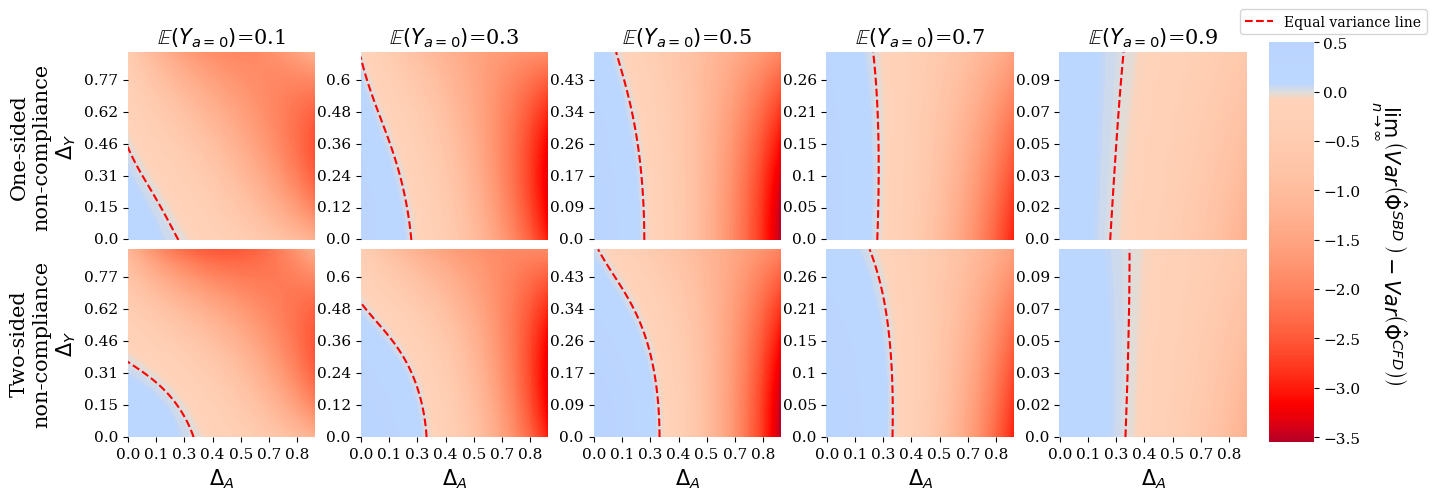

In [6]:
coolwarm = plt.get_cmap('coolwarm_r')

# Create a new colormap with increased saturation
# Increase saturation by scaling the RGB values toward pure colors
def increase_saturation(cmap, factor=1.5):
    colors = cmap(np.linspace(0, 1, 256))  # Get 256 colors from the cmap
    for i in range(len(colors)):
        r, g, b, a = colors[i]
        # Convert to HLS color space to adjust saturation
        h, l, s = colorsys.rgb_to_hls(r, g, b)
        s = min(1.0, s * factor)  # Increase saturation, cap at 1.0
        r, g, b = colorsys.hls_to_rgb(h, l, s)
        colors[i] = (r, g, b, a)
    return ListedColormap(colors)

import colorsys
saturated_cmap = increase_saturation(coolwarm, factor=10)

sns.set_style({'font.family': 'Serif'})
fig, axes = plt.subplots(2, len(y_a0_list), figsize=(15,5), sharex=True)
cbar_ax = fig.add_axes([0.9, .1, .03, .8])
for i, y_a0 in enumerate(y_a0_list):
    curr_one_sided_df = one_sided_df[one_sided_df["P(y|a=0)"]==y_a0].pivot(columns="compliance_rate", index="y_gap", values="difference")
    axes[0, i].contour(np.linspace(0, len(curr_one_sided_df.columns), len(curr_one_sided_df.columns)), 
        np.linspace(0, len(curr_one_sided_df.index), len(curr_one_sided_df.index)), curr_one_sided_df.values, [0], colors='red', linestyles="--")
    sns.heatmap(curr_one_sided_df, ax=axes[0, i], cbar=(i==0), 
                vmin=min(one_sided_df["difference"].min(), two_sided_df["difference"].min()), 
                vmax=max(one_sided_df["difference"].max(), two_sided_df["difference"].max()), 
                cbar_ax=cbar_ax, rasterized=True, cmap=saturated_cmap, center=0)
    axes[0, i].invert_yaxis()
    axes[0, i].set_aspect('equal')
    axes[0, i].set_title(r"$\mathbb{E}(Y_{a=0})$"+f"={y_a0:.1f}", fontsize=15)
    axes[0, i].set_xlabel(None)
    axes[0, i].yaxis.set_tick_params(labelsize=8)
    axes[0, i].xaxis.set_ticks_position('none') 
    axes[0, i].set_yticklabels([str(round(float(label.get_text()), 2)) for label in axes[0, i].get_yticklabels()], fontsize=11)
    axes[0, i].set_yticks(axes[0, i].get_yticks()[::2])
    curr_two_sided_df = two_sided_df[two_sided_df["P(y|a=0)"]==y_a0].pivot(columns="a_gap", index="y_gap", values="difference")
    axes[1, i].contour(np.linspace(0, len(curr_two_sided_df.columns), len(curr_two_sided_df.columns)), 
        np.linspace(0, len(curr_two_sided_df.index), len(curr_two_sided_df.index)), curr_two_sided_df.values, [0], colors='red', linestyles="--")
    sns.heatmap(curr_two_sided_df, ax=axes[1, i], cbar=False, 
                vmin=min(one_sided_df["difference"].min(), two_sided_df["difference"].min()), 
                vmax=max(one_sided_df["difference"].max(), two_sided_df["difference"].max()), 
                rasterized=False, cmap=saturated_cmap, center=0)
    axes[1, i].invert_yaxis()
    axes[1, i].set_aspect('equal')
    axes[1, i].set_xlabel(r"$\Delta_A$", fontsize=15)
    axes[1, i].xaxis.set_tick_params(labelsize=8)
    axes[1, i].yaxis.set_tick_params(labelsize=8)
    axes[1, i].set_xticklabels([str(round(float(label.get_text()), 1))  for label in axes[1, i].get_xticklabels()], rotation=0, fontsize=11)
    axes[1, i].set_xticks(axes[1, i].get_xticks()[::2])
    axes[1, i].set_yticklabels([str(round(float(label.get_text()), 2))  for label in axes[1, i].get_yticklabels()], fontsize=11)
    axes[1, i].set_yticks(axes[1, i].get_yticks()[::2])
    if i > 0: 
        axes[0, i].set_ylabel(None)
        axes[1, i].set_ylabel(None)
    else:
        axes[0, i].set_ylabel(f"One-sided\nnon-compliance\n" + r"$\Delta_Y$", fontsize=15)
        axes[1, i].set_ylabel(f"Two-sided\nnon-compliance\n" + r"$\Delta_Y$", fontsize=15)
cbar_ax.set_ylabel(r"$\lim_{n\rightarrow \infty}\left(Var\left(\hat{\Phi}^{SBD}\right) - Var\left(\hat{\Phi}^{CFD}\right)\right)}$", rotation=-90, labelpad=35, fontsize=15)
cbar_ax.tick_params(labelsize=11)
fig.legend(handles=[Line2D([0], [0], label='Equal variance line', color='red', linestyle="--")], bbox_to_anchor=(1.01, 0.98))
fig.subplots_adjust(wspace=0.01, hspace=0.05)
fig.savefig(f"outputs/variance.jpg", bbox_inches='tight',format='jpg', dpi=500)
fig.savefig(f"outputs/variance.pdf", bbox_inches='tight')